In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install --upgrade git+https://github.com/NazirNayal8/analyze.git

  Cloning https://github.com/NazirNayal8/analyze.git to /tmp/pip-req-build-dka1g84w
  Running command git clone --filter=blob:none --quiet https://github.com/NazirNayal8/analyze.git /tmp/pip-req-build-dka1g84w
  Resolved https://github.com/NazirNayal8/analyze.git to commit 3b95c6d73ef9e966fd54a2b5461e812eb126a5d1
  Preparing metadata (setup.py) ... done
  Created wheel for analysis: filename=analysis-0.0.17-py3-none-any.whl size=9158 sha256=877ab6ad0f19b253c97dabdbd883ff3c6b6bb78c47671562c5b5cbb99ee657e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-lhls42fa/wheels/f0/95/e6/15637597f0b2f4ae53c88586c42efba99537e71b4edd8601ac
Successfully built analysis
  Attempting uninstall: analysis
    Found existing installation: analysis 0.0.14
    Uninstalling analysis-0.0.14:
      Successfully uninstalled analysis-0.0.14


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import random

from torch.utils.data import DataLoader, Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from datasets.lost_and_found import LostAndFound
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer


from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

# Paths

Here subscript $bi$ refers to the $i^{th}$ checkpoint before the last. This means that b1 is the checkpoint that was saved right before the final one was saved and so on. A checkpoint is saved every 5000 iterations.

In [5]:
config_path = 'model_logs/mask2former_dec_layers_2_res5_only/config.yaml'
ckpt_path = 'model_logs/mask2former_dec_layers_2_res5_only/model_final.pth'
ckpt_path_b1 = 'model_logs/mask2former_dec_layers_2_res5_only/model_0084999.pth'
ckpt_path_b2 = 'model_logs/mask2former_dec_layers_2_res5_only/model_0079999.pth'

ckpt_paths = {
    'final': ckpt_path,
    'b1': ckpt_path_b1,
    'b2': ckpt_path_b2,
}


# Loading the Model

In [6]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name='final'):
    
    args = edict({'config_file': config_path, 'eval-only':True, 'opts':[]})
    config = setup(args)

    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model


In [7]:
model = get_model('final')

[09/06 16:58:30 detectron2]: Rank of current process: 0. World size: 1
[09/06 16:58:30 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          510.85.

[09/06 16:58:30 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 10
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: cho

[09/06 16:58:30 detectron2]: Full config saved to ./model_logs/mask2former_dec_layers_2_res5_only/config.yaml
[09/06 16:58:30 d2.utils.env]: Using a generated random seed 30899267
[09/06 16:58:33 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): 

[09/06 16:58:33 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_dec_layers_2_res5_only/model_final.pth ...


# Dataset Configs

In [8]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})

laf_config = edict(
    dataset_root='/home/user/datasets/LostAndFound',
)



# Create Datasets

In [9]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)

# Lost And Found
transforms_laf = A.Compose([
    ToTensorV2()
])

laf_dataset = LostAndFound(laf_config, transforms_laf) 
loader_laf = DataLoader(laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Util Functions

In [10]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}])
        
    return out[0]['sem_seg'].unsqueeze(0)

# Closed-Set Evaluation

In [10]:
analyzer = MaxLogitsAnalyzer(model=model, inference_func=get_logits)

## Cityscapes mIoU

In [11]:
mIoU_cityscapes = analyzer.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

  0%|                                                   | 0/500 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|█████████████████████████████████████████| 500/500 [02:11<00:00,  3.80it/s]


In [12]:
mIoU_cityscapes

tensor(0.8225)

## BDD100K mIoU

In [13]:
mIoU_bdd100k = analyzer.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|███████████████████████████████████████| 1000/1000 [01:33<00:00, 10.75it/s]


In [14]:
mIoU_bdd100k

tensor(0.5676)

# OOD Evaluation

In [11]:
ood_evaluator = OODEvaluator(model, get_logits)

## Road Anomaly

In [16]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration: 100%|████████████████████████| 60/60 [00:06<00:00,  9.61it/s]


Max Logits: AUROC score: 0.9586990224154863
Max Logits: AUPRC score: 0.7731942343561198
Max Logits: FPR@TPR95: 0.16903175948077565


In [17]:
imgs_ra = ood_evaluator.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

### Fishyscapes LaF

In [19]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration: 100%|██████████████████████| 100/100 [00:21<00:00,  4.68it/s]


Max Logits: AUROC score: 0.9569569097621132
Max Logits: AUPRC score: 0.5852767900411247
Max Logits: FPR@TPR95: 0.2214666113686159


In [20]:
imgs_fs_laf = ood_evaluator.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

### Fishyscapes Static

In [15]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration:   0%|                                                                                                                                                            | 0/30 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.13it/s]


Calculating Metrics for 53335838 Points ...
Max Logits: AUROC score: 0.9922463552468973
Max Logits: AUPRC score: 0.8421448756037171
Max Logits: FPR@TPR95: 0.03928251275044886


In [23]:
imgs_fs_static = ood_evaluator.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

### Lost And Found

In [11]:
anomaly_score_laf, ood_gts_laf, preds_laf = ood_evaluator.compute_max_logit_scores(
    #loader=DataLoader(Subset(laf_dataset, np.random.choice(np.arange(len(laf_dataset)), 800, replace=False)), batch_size=1, shuffle=False, num_workers=15),
    loader=loader_laf,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=1250
)

metrics_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_laf,
    ood_gts=ood_gts_laf,
    verbose=True
)

Dataset Iteration:   0%|                                                                                                                                                          | 0/1203 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1203/1203 [03:38<00:00,  5.50it/s]


Calculating Metrics for 383771805 Points ...
Max Logits: AUROC score: 0.9093340935330281
Max Logits: AUPRC score: 0.5421627517646225
Max Logits: FPR@TPR95: 0.5538127683104361


In [78]:
ood_mask = (ood_gts_laf == 1)
ind_mask = (ood_gts_laf == 0)

ood_out = anomaly_score_laf[ood_mask]
ind_out = anomaly_score_laf[ind_mask]

ood_out = np.unique(np.round(ood_out, 10))
ind_out = np.unique(np.round(ind_out, 10))

ood_label = np.ones(len(ood_out))
ind_label = np.zeros(len(ind_out))

val_out = np.concatenate((ind_out, ood_out))
val_label = np.concatenate((ind_label, ood_label))

In [79]:
len(val_out)

21631915

In [80]:
auroc, aupr, fpr = ood_evaluator.calculate_ood_metrics(val_out, val_label)

print(f'Max Logits: AUROC score: {auroc}')
print(f'Max Logits: AUPRC score: {aupr}')
print(f'Max Logits: FPR@TPR95: {fpr}')

Max Logits: AUROC score: 0.7663816230739116
Max Logits: AUPRC score: 0.6297121338926025
Max Logits: FPR@TPR95: 0.8732232690197015


In [ ]:
# Max Logits: AUROC score: 0.7635324685648839
# Max Logits: AUPRC score: 0.6216699920945048
# Max Logits: FPR@TPR95: 0.8821651142995772

In [66]:
v_u = np.unique(val_out)

In [68]:
len(v_u)

22421570

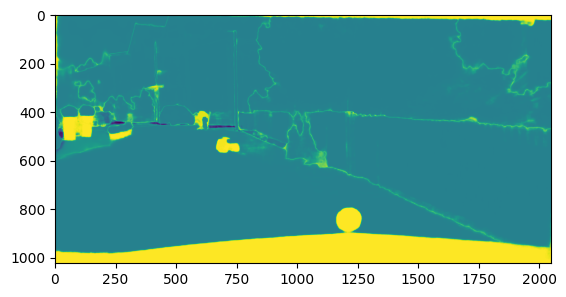

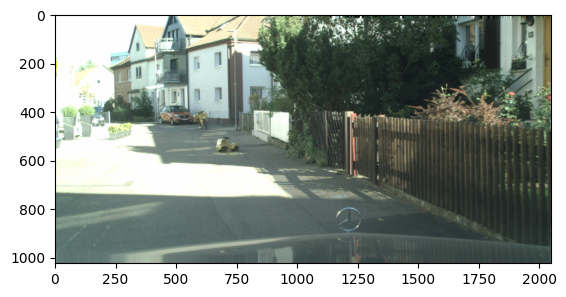

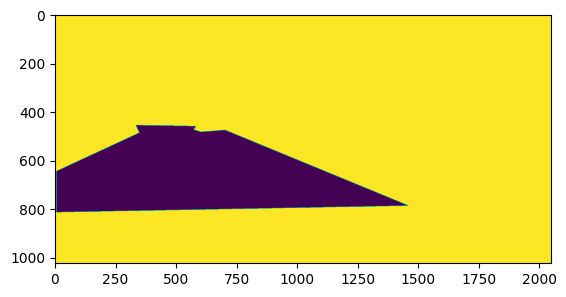

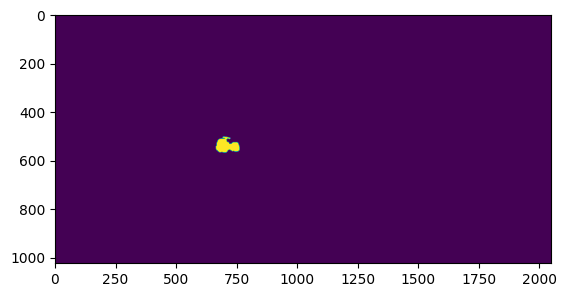

In [60]:
idx = -230

im, lb = laf_dataset[idx]

plt.imshow(anomaly_score_laf[idx].squeeze())
plt.show()
plt.imshow(im.permute(1, 2, 0))
plt.show()
plt.imshow(laf_dataset[idx][1])
plt.show()
m = lb.clone()
k = 1
m[lb == k] = 1
m[lb != k] = 0
plt.imshow(m)
plt.show()

In [ ]:
imgs_laf = ood_evaluator.get_imgs(
    laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='lost_and_found',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_laf,
    ood_gts=ood_gts_laf,
    preds=preds_laf,
    anomaly_score= anomaly_score_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_laf
)

### Road Anomaly 21 (Qualitative)

In [25]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration: 100%|██████████████████████| 110/110 [00:11<00:00,  9.45it/s]


In [26]:
imgs_ra_21 = ood_evaluator.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [ ]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

In [132]:
imgs_bdd100k = ood_evaluator.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_b_replication_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

# Smoothed Evaluation

In [13]:
ood_evaluator = OODEvaluator(model, get_logits)

### Road Anomaly

In [14]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    use_gaussian_smoothing=True,
    return_preds=True,
)

metrics_ra = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration:   0%|                                 | 0/60 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Dataset Iteration: 100%|████████████████████████| 60/60 [00:06<00:00,  9.21it/s]


Calculating Metrics for 55296000 Points ...
Max Logits: AUROC score: 0.9592983896316669
Max Logits: AUPRC score: 0.775143322228328
Max Logits: FPR@TPR95: 0.16918350797971507


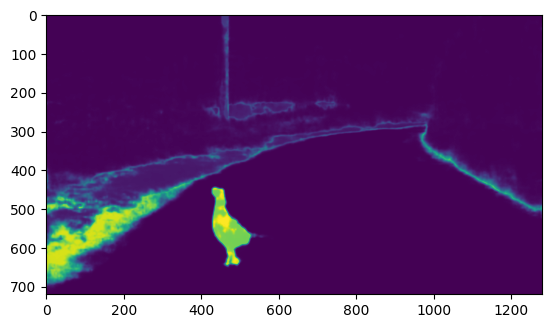

In [32]:
plt.imshow(anomaly_score_ra[10].squeeze())
plt.show()

In [15]:
imgs_ra = ood_evaluator.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

### Fishyscapes LaF

In [31]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    use_gaussian_smoothing=True,
    return_preds=True,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration: 100%|██████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9583216040337403
Max Logits: AUPRC score: 0.5762274339836083
Max Logits: FPR@TPR95: 0.2185549284932351


In [20]:
imgs_fs_laf = ood_evaluator.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

### Fishyscapes Static

In [33]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    use_gaussian_smoothing=True,
    return_preds=True,
)

metrics_fs_static = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration: 100%|████████████████████████| 30/30 [00:11<00:00,  2.72it/s]


Calculating Metrics for 53335838 Points ...
Max Logits: AUROC score: 0.9923275217627676
Max Logits: AUPRC score: 0.8453929329390828
Max Logits: FPR@TPR95: 0.03569240600195042


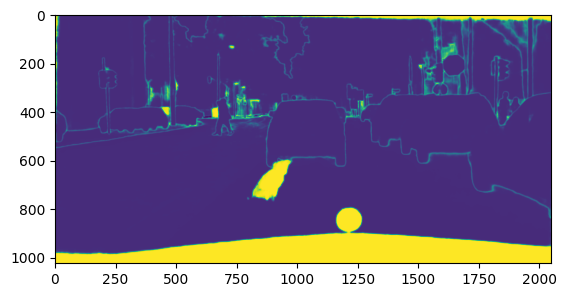

In [34]:
plt.imshow(anomaly_score_fs_static[0].squeeze())
plt.show()

In [23]:
imgs_fs_static = ood_evaluator.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

### Lost And Found

In [11]:
anomaly_score_laf, ood_gts_laf, preds_laf = ood_evaluator.compute_max_logit_scores(
    #loader=DataLoader(Subset(laf_dataset, np.random.choice(np.arange(len(laf_dataset)), 800, replace=False)), batch_size=1, shuffle=False, num_workers=15),
    loader=loader_laf,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=1250
)

metrics_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_laf,
    ood_gts=ood_gts_laf,
    verbose=True
)

Dataset Iteration:   0%|                                                                                                                                                          | 0/1203 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1203/1203 [03:38<00:00,  5.50it/s]


Calculating Metrics for 383771805 Points ...
Max Logits: AUROC score: 0.9093340935330281
Max Logits: AUPRC score: 0.5421627517646225
Max Logits: FPR@TPR95: 0.5538127683104361


In [78]:
ood_mask = (ood_gts_laf == 1)
ind_mask = (ood_gts_laf == 0)

ood_out = anomaly_score_laf[ood_mask]
ind_out = anomaly_score_laf[ind_mask]

ood_out = np.unique(np.round(ood_out, 10))
ind_out = np.unique(np.round(ind_out, 10))

ood_label = np.ones(len(ood_out))
ind_label = np.zeros(len(ind_out))

val_out = np.concatenate((ind_out, ood_out))
val_label = np.concatenate((ind_label, ood_label))

# Sample Exclusion Attempts

In [55]:
fs_laf_exc = [3,17, 22,46,71,77,83,89]# [8,29,31,35,44,48,50,51,74,99]
fs_laf_idx = [x for x in np.arange(len(fs_laf_dataset)) if x not in fs_laf_exc]

loader_fs_laf_exc = DataLoader(Subset(fs_laf_dataset, fs_laf_idx), batch_size=1, num_workers=15)

In [56]:
### Fishyscapes LaF

anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_laf_exc,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration: 100%|████████████████████████| 92/92 [00:17<00:00,  5.16it/s]


Calculating Metrics for 156547344 Points ...
Max Logits: AUROC score: 0.9465255154010026
Max Logits: AUPRC score: 0.5232111558768445
Max Logits: FPR@TPR95: 0.27505765495798573


In [ ]:
# Smoothened
# Max Logits: AUROC score: 0.9665195385689064
# Max Logits: AUPRC score: 0.6447636458268658
# Max Logits: FPR@TPR95: 0.16276450479999421

# Understanding Effects on Metrics

In [341]:
import torch.nn as nn
import math
from torchvision import transforms
from kornia.morphology import dilation, erosion
from scipy import ndimage as ndi
from sklearn.metrics import roc_curve, auc, average_precision_score

In [250]:
class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False)
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight)))

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False)
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel)


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)

def smooth(x, kernel_size=7, sigma=1):
    smoother = transforms.GaussianBlur(kernel_size, sigma=sigma)
    return smoother(torch.from_numpy(x).unsqueeze(0)).squeeze().numpy()

selem = torch.ones((3, 3))
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1))

d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1))
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1))
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1))
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1))
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1))
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1))
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1))
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1))
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1))

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}

for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)




def smooth_boundaries(x, preds, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
    boundary_smoother = BoundarySuppressionWithSmoothing(
        boundary_suppression=boundary_suppression, 
        boundary_width=boundary_width, 
        boundary_iteration=boundary_iteration,
        dilated_smoothing=dilated_smoothing, 
        kernel_size=kernel_size, 
        dilation=dilation,
    )
    with torch.no_grad():
        score = boundary_smoother(torch.from_numpy(x).unsqueeze(0), torch.from_numpy(preds))
    return score.squeeze().numpy()

def find_boundaries(x):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    
    taken from SML
    """
    
   # x = torch.from_numpy(x)#.unsqueeze(0)
    assert len(x.shape) == 4, f"given size is {x.shape}"
    boundaries = (dilation(x.float(), selem_dilation) != erosion(x.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
   
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries


In [66]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration: 100%|██████████████████████| 100/100 [00:19<00:00,  5.17it/s]


In [67]:
metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9569569097621132
Max Logits: AUPRC score: 0.5852767900411247
Max Logits: FPR@TPR95: 0.2214666113686159


In [79]:
ood_gts_fs_laf.shape

(100, 1, 1024, 2048)

In [85]:
anomaly_score_fs_laf = anomaly_score_fs_laf.squeeze()
ood_gts_fs_laf = ood_gts_fs_laf.squeeze()

ood_gts_color = ood_gts_fs_laf.copy()
ood_gts_color[ood_gts_fs_laf == 1] = 128

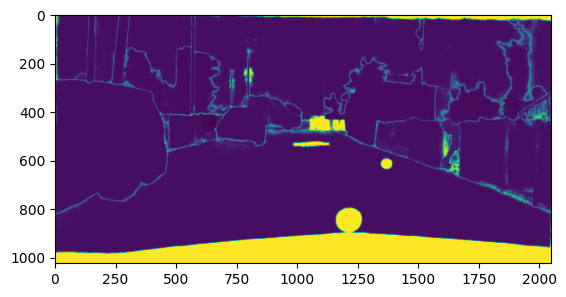

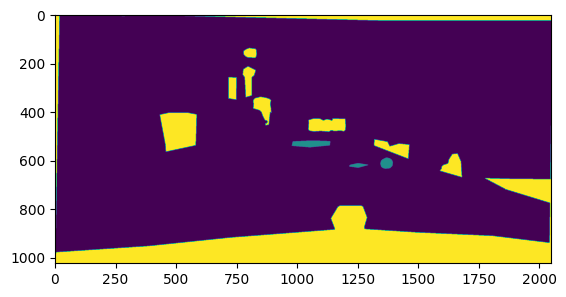

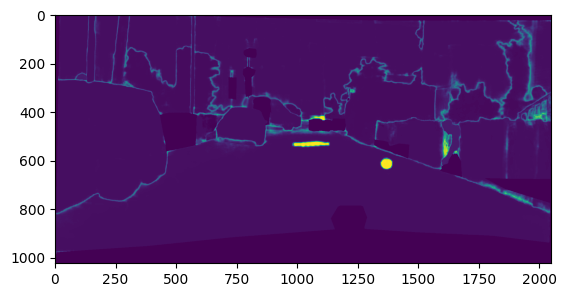

Calculating Metrics for 1760014 Points ...
Max Logits: AUROC score: 0.9329625879098626
Max Logits: AUPRC score: 0.6054545092682249
Max Logits: FPR@TPR95: 0.40590756753859714


In [505]:
idx = 65
plt.imshow(anomaly_score_fs_laf[idx])
plt.show()
plt.imshow(ood_gts_color[idx])
plt.show()

filtered_score = anomaly_score_fs_laf[idx].copy()
filtered_score[ood_gts_fs_laf[idx] == 255] = anomaly_score_fs_laf[idx].min()
plt.imshow(filtered_score)
plt.show()

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf[idx],
    ood_gts=ood_gts_fs_laf[idx],
    verbose=True
)

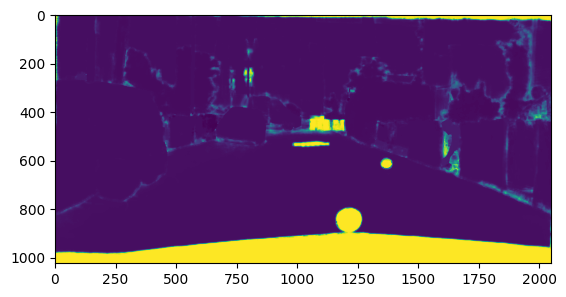

Calculating Metrics for 1760014 Points ...
Max Logits: AUROC score: 0.9359577388561973
Max Logits: AUPRC score: 0.6090860948683726
Max Logits: FPR@TPR95: 0.40284237401974815


In [506]:
patched_score = anomaly_score_fs_laf[idx].copy()

patched_score = smooth_boundaries(anomaly_score_fs_laf[idx], preds_fs_laf[idx], dilated_smoothing=False)


# patched_score[0:800,0:800] = anomaly_score_fs_laf[idx].min()
# patched_score[0:800,1400:] = anomaly_score_fs_laf[idx].min()
#patched_score[0:400,800:1400] = anomaly_score_fs_laf[idx].min()
# patched_score[ood_gts_fs_laf[idx] != 1] = anomaly_score_fs_laf[idx].min()
# boundaries = find_boundaries(preds_fs_laf[idx].copy())
# patched_score[(boundaries == 1) & (ood_gts_fs_laf[idx] != 1)] = anomaly_score_fs_laf[idx].min()
plt.imshow(patched_score)
plt.show()

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=patched_score,
    ood_gts=ood_gts_fs_laf[idx],
    verbose=True
)

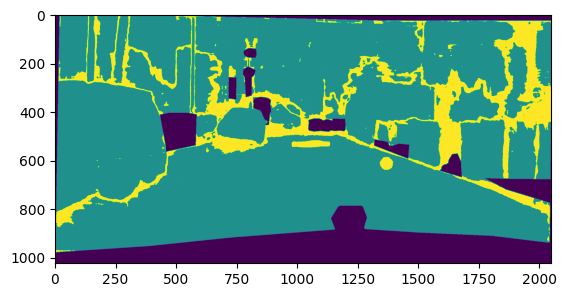

In [508]:
id_region = anomaly_score_fs_laf[idx].copy()
thr = -0.992
id_region[(anomaly_score_fs_laf[idx] > thr) & (ood_gts_fs_laf[idx] != 255)] = 256
id_region[anomaly_score_fs_laf[idx] < thr] = 128
id_region[ood_gts_fs_laf[idx] == 255] = 0

plt.imshow(id_region)
plt.show()

In [507]:
ood_mask = (ood_gts_fs_laf[idx] == 1)
ind_mask = (ood_gts_fs_laf[idx] == 0)

ood_out = anomaly_score_fs_laf[idx][ood_mask]
ind_out = anomaly_score_fs_laf[idx][ind_mask]

ood_label = np.ones(len(ood_out))
ind_label = np.zeros(len(ind_out))

val_out = np.concatenate((ind_out, ood_out))
val_label = np.concatenate((ind_label, ood_label))

fpr, tpr, thresholds = roc_curve(val_label, val_out)
fpr95_threshold = np.where(tpr > 0.95)[0].min()

print(thresholds[fpr95_threshold])

-0.99969506


In [447]:
w = np.where(thresholds < -0.6)[0].min()

print("i", w)
print("FPR", fpr[w])
print("TPR", tpr[w])

i 1174
FPR 0.006283190331040099
TPR 0.8531102979613173


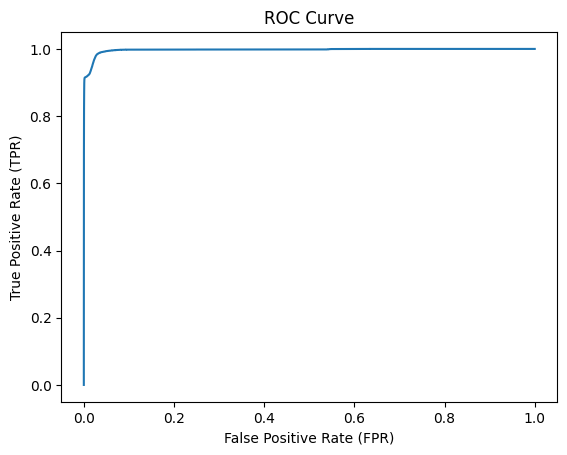

In [371]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

In [78]:
val_min = anomaly_score_fs_laf[idx][].min() 
val_max = anomaly_score_fs_laf[idx][].max()
val_mean = anomaly_score_fs_laf[idx][].mean()
val_std = anomaly_score_fs_laf[idx][].std()

val_min, val_max, val_mean, val_std

(-1.3015171, -2.2200948e-10, -0.8406649, 0.3340135)

In [87]:
ood_min = anomaly_score_fs_laf[ood_gts_fs_laf == 1].min() 
ood_max = anomaly_score_fs_laf[ood_gts_fs_laf == 1].max()
ood_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 1].mean()
ood_std = anomaly_score_fs_laf[ood_gts_fs_laf == 1].std()

print("OOD Min", ood_min)
print("OOD Max", ood_max)
print("OOD Mean", ood_mean)
print("OOD STD", ood_std)

OOD Min -1.4879445
OOD Max -1.3194271e-08
OOD Mean -0.26045543
OOD STD 0.38001043


In [88]:
id_min = anomaly_score_fs_laf[ood_gts_fs_laf == 0].min() 
id_max = anomaly_score_fs_laf[ood_gts_fs_laf == 0].max()
id_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 0].mean()
id_std = anomaly_score_fs_laf[ood_gts_fs_laf == 0].std()

print("ID Min", id_min)
print("ID Max", id_max)
print("ID Mean", id_mean)
print("ID STD", id_std)

ID Min -1.9218879
ID Max -1.0070045e-06
ID Mean -0.99125606
ID STD 0.112901896


In [89]:
void_min = anomaly_score_fs_laf[ood_gts_fs_laf == 255].min() 
void_max = anomaly_score_fs_laf[ood_gts_fs_laf == 255].max()
void_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 255].mean()
void_std = anomaly_score_fs_laf[ood_gts_fs_laf == 255].std()

print("Void Min", void_min)
print("Void Max", void_max)
print("Void Mean", void_mean)
print("Void STD", void_std)

Void Min -1.92052
Void Max -1.4615757e-12
Void Mean -0.34189525
Void STD 0.44818607


In [83]:
### Normalization has no effect

val_min = anomaly_score_fs_laf.min() 
val_max = anomaly_score_fs_laf.max()

anomaly_score_fs_laf_norm = (anomaly_score_fs_laf - val_min) / (val_max - val_min)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf_norm,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9569569097333395
Max Logits: AUPRC score: 0.585261490019791
Max Logits: FPR@TPR95: 0.2214666113686159
